In [220]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [221]:
def clean_data(df):
    """
    Cleans the data by handling missing/odd values in the RET and PRC columns.
    
    For RET:
      - Replaces the special missing codes (-66.0, -77.0, -88.0, -99.0) with NaN.
    
    For PRC:
      - If the price is 0, it is set to NaN (indicating missing price).
      - If the price is negative, its absolute value is taken (since the negative sign
        is only a symbol to denote a bid/ask average).
    
    Parameters:
      df : pandas.DataFrame with columns including 'RET' and 'PRC'.
      
    Returns:
      A cleaned DataFrame with missing or anomalous values handled.
    """
    # --- Clean RET: Replace special codes with NaN ---
    missing_return_codes = [-66.0, -77.0, -88.0, -99.0]
    df["RET"] = df["RET"].replace(missing_return_codes, np.nan)
    
    # --- Clean PRC: Convert negative prices to positive; mark zero prices as NaN ---
    def clean_price(x):
        if x == 0:
            return np.nan
        else:
            return abs(x)
    
    df["PRC"] = df["PRC"].apply(clean_price)
    
    # Optionally, drop rows where either PRC or RET is missing.
    df_clean = df.dropna(subset=["PRC", "RET"]).copy()
    
    return df_clean

In [222]:
def single_stock_opt(df: DataFrame, 
                     window_length: int, 
                     start_index: int, 
                     forecast_horizon: int, 
                     smoothing_window: int, 
                     alpha_scale: float, 
                     beta: float, 
                     tau: float, 
                     w: float, 
                     penalty: float, 
                     Q_target: float, 
                     Q0: float, 
                     J0: float, 
                     gamma0: float, 
                     gammaT: float):
    '''
    Performs multi-period optimization for a single stock with given input parameters.
    
    Returns data over windowed period, the optimized impact states J_opt, 
    and optimized trade schedule Q_history
    
    '''
    
    df_window = df.iloc[start_index:start_index + window_length + 1].copy()
    T = window_length
    
    prices = df_window["PRC"].values  # length T+1
    dates = df_window["date"].values
    
    # synthetic alpha signal construction
    df_window["raw_alpha"] = (df_window["PRC"].shift(-forecast_horizon) / df_window["PRC"] - 1)
    df_window["alpha"] = df_window["raw_alpha"].rolling(smoothing_window, min_periods=1).mean()
    df_window["alpha"].fillna(method="ffill", inplace=True)
    
    df_window["alpha"] *= alpha_scale
    
    t = np.arange(len(df_window))
    df_window["alpha"] *= np.exp(-beta * t)
    
    alpha = df_window["alpha"].values[:T+1]  # alpha_0,...,alpha_T
    delta_alpha = np.diff(alpha)
    
    # setting remaining parameters 
    gamma = np.linspace(gamma0, gammaT, T+1)
    lambda_vals = np.exp(gamma)
    delta_gamma = np.diff(gamma)
    
    # decision variable: J \in R^(T+1), where J[0] = J0 is fixed.
    J = cp.Variable(T+1)

    objective_terms = []
    
    # sum from k=0 to T-1
    for k in range(T):
        term_k = (np.exp(-gamma[k]) *
                  ( J[k] * delta_alpha[k] 
                    + (1/tau + delta_gamma[k]) * alpha[k] * J[k]
                    - (1/tau) * (w * cp.square(J[k])) 
                    - delta_gamma[k] * (0.5 * w * cp.square(J[k]) )
                  )
                 )
        objective_terms.append(term_k)
        
    # terminal term at k=T:
    terminal_term = np.exp(-gamma[T]) * (alpha[T] * J[T] - 0.5 * w * cp.square(J[T]))
    objective_terms.append(terminal_term)
    
    # deviation term:
    position_increment = []
    for i in range(T):
        position_increment.append((J[i+1] - (1 - 1/tau)*J[i]) / lambda_vals[i])
    Q_T_expr = Q0 + cp.sum(cp.hstack(position_increment))
    deviation = Q_target - Q_T_expr
    penalty_term = - penalty * cp.square(deviation)
    
    # full objective:
    objective = cp.Maximize(cp.sum(cp.hstack(objective_terms)) + penalty_term)

    constraints = [J[0] == J0]

    # formulate problem
    prob = cp.Problem(objective, constraints)
    
    
    # solve problem 
    try:
        prob.solve(solver=cp.SCS, verbose=True)
    except Exception as e:
        print("Solver failed:", e)
        
    print("Optimal value:", prob.value)
    J_opt = J.value  # optimal J_t sequence
    
    
    # recover portfolio position Q_t
    Q_history = [Q0]
    for i in range(T):
        delta_Q_i = (J_opt[i+1] - (1 - 1/tau)*J_opt[i]) / lambda_vals[i]
        Q_history.append(Q_history[-1] + delta_Q_i)
    Q_history = np.array(Q_history)
    
    
    return df_window, J_opt, Q_history

In [243]:
def plot(df_window: DataFrame, 
         J_opt: DataFrame, 
         Q_history: DataFrame, 
         Q_target: float, 
         window_length: int):
    
    '''
    Plots the result of single stock optimization. 
    Plots both impact state J_t and portfolio positions Q_t over time.
    
    '''
    
    dates = df_window["date"].values

    plt.figure(figsize=(12,6))
    plt.plot(dates, J_opt, marker='o')
    plt.xlabel("Date")
    plt.ylabel("Optimal Impact State J_t")
    plt.title("Optimal Impact State over Time")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12,6))
    plt.plot(dates, Q_history, marker='o', label="Optimized Portfolio")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Position Q_t")
    plt.title(f'Optimizal Portfolio Trajectory for T = {window_length}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # final metrics
    final_Q = Q_history[-1]
    print(f"Final portfolio position: {final_Q:.2f} (Target: {Q_target})")
    print(f"Deviation from target: {abs(final_Q - Q_target):.2f}")

In [244]:
df_og = pd.read_csv("crsp_nflx.csv", parse_dates=["date"])
df_og.sort_values("date", inplace=True)
df_og.reset_index(drop=True, inplace=True)
df_og = df_og.dropna(subset=["PRC"])

df = clean_data(df_og)

In [245]:
df

,PERMNO,date,TICKER,CUSIP,PRC,VOL,RET,SHROUT,NUMTRD,RETX
0,89393,2019-01-02,NFLX,64110L10,267.66000,11679228,0.000000,436599,128527.0,0.000000
1,89393,2019-01-03,NFLX,64110L10,271.20001,14969547,0.013226,436599,142265.0,0.013226
2,89393,2019-01-04,NFLX,64110L10,297.57001,19329677,0.097234,436599,197495.0,0.097234
3,89393,2019-01-07,NFLX,64110L10,315.34000,18620017,0.059717,436599,219876.0,0.059717
4,89393,2019-01-08,NFLX,64110L10,320.26999,15362392,0.015634,436599,155541.0,0.015634
...,...,...,...,...,...,...,...,...,...,...
1505,89393,2024-12-24,NFLX,64110L10,932.12000,2301447,0.022678,427458,76643.0,0.022678
1506,89393,2024-12-26,NFLX,64110L10,924.14001,2318046,-0.008561,427458,87233.0,-0.008561
1507,89393,2024-12-27,NFLX,64110L10,907.54999,3189948,-0.017952,427458,116631.0,-0.017952
1508,89393,2024-12-30,NFLX,64110L10,900.42999,2184055,-0.007845,427458,84238.0,-0.007845


## Test1: T = 50, Q0 = Qtarget = 100

In [246]:
window_length1 = 50
start_index = 50

forecast_horizon = 5
smoothing_window = 5
alpha_scale = 0.5
beta = 0.1

tau = 5.0
w = 0.05
penalty = 0.01
Q_target = 100.0
Q0 = 100.0
J0 = 0

gamma0 = 0.0
gammaT = 0.1

In [247]:
window1, J_opt1, Q_history1 = single_stock_opt(df, 
                window_length1, start_index, 
                forecast_horizon, smoothing_window, alpha_scale, beta, 
                tau, w, penalty, Q_target, Q0, J0, 
                gamma0, gammaT)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Apr 03 06:05:21 PM: Your problem has 51 variables, 1 constraints, and 0 parameters.
(CVXPY) Apr 03 06:05:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 03 06:05:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 03 06:05:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 03 06:05:21 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 03 06:05:21 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeM

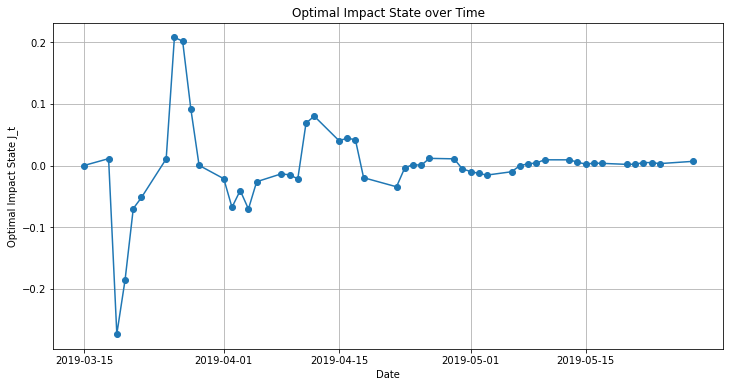

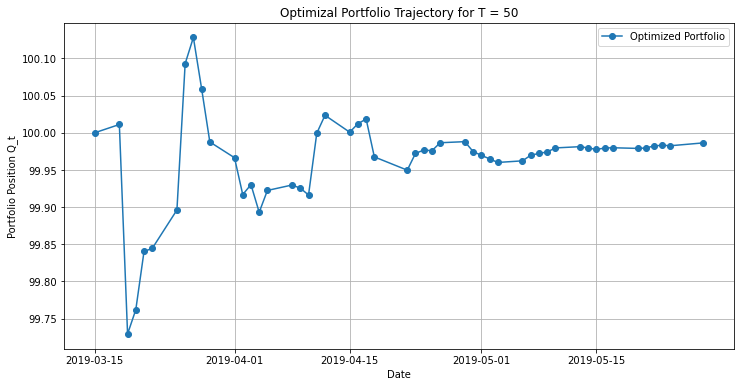

Final portfolio position: 99.99 (Target: 100.0)
Deviation from target: 0.01


In [248]:
plot(window1, J_opt1, Q_history1, Q_target, window_length1)

## Test2: T = 100, Q0 = Qtarget = 100

In [249]:
window_length2 = 100
start_index = 50

forecast_horizon = 5
smoothing_window = 5
alpha_scale = 0.5
beta = 0.1

tau = 5.0
w = 0.05
penalty = 0.01
Q_target = 100.0
Q0 = 100.0
J0 = 0

gamma0 = 0.0
gammaT = 0.1

In [250]:
window2, J_opt2, Q_history2 = single_stock_opt(df, 
                window_length2, start_index, 
                forecast_horizon, smoothing_window, alpha_scale, beta, 
                tau, w, penalty, Q_target, Q0, J0, 
                gamma0, gammaT)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Apr 03 06:05:28 PM: Your problem has 101 variables, 1 constraints, and 0 parameters.
(CVXPY) Apr 03 06:05:28 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 03 06:05:28 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 03 06:05:28 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 03 06:05:28 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 03 06:05:28 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Cone

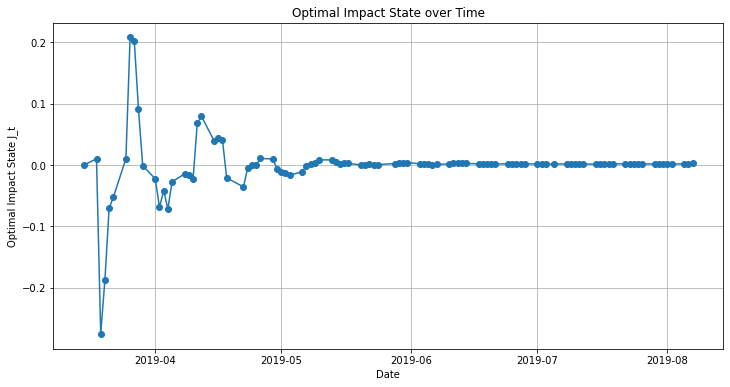

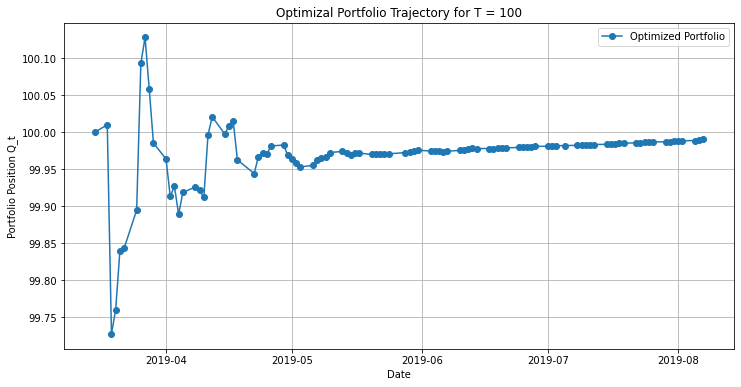

Final portfolio position: 99.99 (Target: 100.0)
Deviation from target: 0.01


In [251]:
plot(window2, J_opt2, Q_history2, Q_target, window_length2)

### Overlayed plots of first 50 days (T=50 vs. T=100)

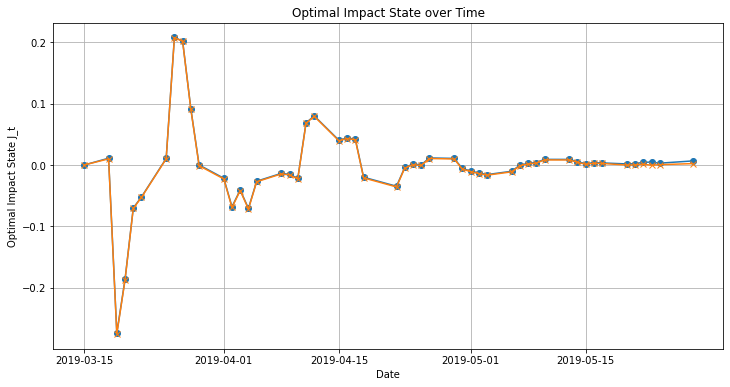

In [232]:
dates = window1["date"][:window_length1+1].values

plt.figure(figsize=(12,6))
plt.plot(dates, J_opt1, marker='o')
plt.plot(dates, J_opt2[:window_length1+1], marker='x')
plt.xlabel("Date")
plt.ylabel("Optimal Impact State J_t")
plt.title("Optimal Impact State over Time")
plt.grid(True)
plt.show()

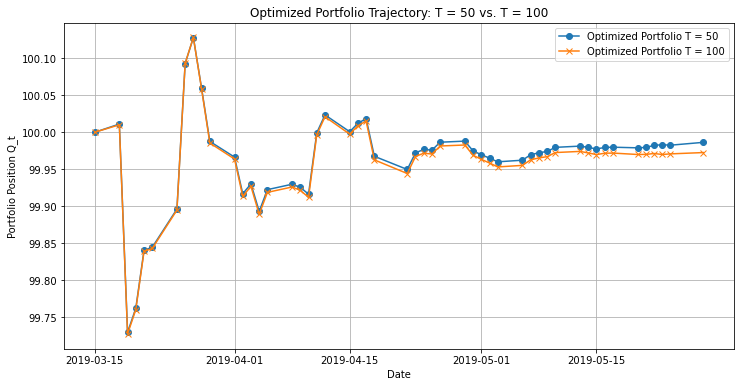

In [233]:
dates = window1["date"][:window_length1+1].values

plt.figure(figsize=(12,6))
plt.plot(dates, Q_history1, marker='o', label="Optimized Portfolio T = 50")
plt.plot(dates, Q_history2[:window_length1+1], marker='x', label="Optimized Portfolio T = 100")
plt.xlabel("Date")
plt.ylabel("Portfolio Position Q_t")
plt.title("Optimized Portfolio Trajectory: T = 50 vs. T = 100")
plt.legend()
plt.grid(True)
plt.show()